<a href="https://colab.research.google.com/github/dinaldoap/jit-sdp-nn/blob/master/notebook/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
%cd /workspace/

/workspace


In [58]:
from jitsdp import metrics
from jitsdp.classifier import Classifier
from jitsdp.pipeline import Pipeline
from jitsdp.plot import plot_recalls_gmean

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from scipy.stats import mstats
import math
import re

import logging

In [59]:
logging.getLogger('').handlers = []
logging.basicConfig(filename='notebook/mlp.log', filemode='w', level=logging.DEBUG)

In [60]:
df = pd.read_csv('https://raw.githubusercontent.com/dinaldoap/jit-sdp-data/master/brackets.csv')
df.head()

,commit_hash,author_name,author_date_unix_timestamp,author_email,author_date,commit_message,fix,classification,linked,contains_bug,...,fileschanged,lt,ndev,age,nuc,exp,rexp,sexp,glm_probability,repository_id
0,b96625a4b8e0aaaf58ca56082ed29dbc588e9379,ficristo,1512664331,ficristo.work@gmail.com,Thu Dec 7 17:32:11 2017 +0100,Remove PanelManager (#11589),False,None,False,False,...,"src/brackets.js,CAS_DELIMITER,src/search/Searc...",0.0,1.0,0.0,0.0,2.0,0.0,2.0,0.450896,62af12f4-9856-421d-a18b-16a4d7b39c63
1,51417390f9b7aedf983f0f847d578dd819765c6d,ficristo,1512664256,ficristo.work@gmail.com,Thu Dec 7 17:30:56 2017 +0100,Add wrapper functions to call the fs-extra one...,False,Feature Addition,False,False,...,"test/node/TestingDomain.js,CAS_DELIMITER",0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.401964,62af12f4-9856-421d-a18b-16a4d7b39c63
2,13af302a2a5bbbe459fa7ac060203dd410de97e9,Naveen Choudhary,1512657100,navch@users.noreply.github.com,Thu Dec 7 20:01:40 2017 +0530,Merge pull request #13945 from JungGaBin/fixtt...,False,Merge,False,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201657,62af12f4-9856-421d-a18b-16a4d7b39c63
3,63e07fd375fcf6a29fe37b566464d4591f8f0b69,Prashanth Nethi,1512448426,prashant@adobe.com,Tue Dec 5 10:03:46 2017 +0530,Merge pull request #13852 from toryherman/1377...,False,Merge,False,False,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.201657,62af12f4-9856-421d-a18b-16a4d7b39c63
4,cf8dc16872045735ba485a90eec104b5517a909a,JungGaBin,1511896569,jgb5131@naver.com,Wed Nov 29 04:16:09 2017 +0900,Correct typo (#13938)Inpsector -> Inspector,False,None,False,False,...,"test/spec/LiveDevelopment-test.js,CAS_DELIMITER",0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.402032,62af12f4-9856-421d-a18b-16a4d7b39c63


In [61]:
label_col = 'target'
features_cols = ['fix', 'ns', 'nd', 'nf', 'entrophy', 'la', 'ld', 'lt', 'ndev', 'age', 'nuc', 'exp', 'rexp', 'sexp']
preprocess_cols = ['commit_hash', 'author_date_unix_timestamp', 'fixes'] + features_cols + ['contains_bug']
df_preprocess = df[preprocess_cols].copy()
# timestamp
df_preprocess = df_preprocess.rename(columns={'author_date_unix_timestamp': 'timestamp',
                                                'contains_bug': label_col})
# filter rows with missing data 
df_preprocess = df_preprocess.dropna(subset=['fix'])
# timeline order
df_preprocess = df_preprocess[::-1]
df_preprocess = df_preprocess.reset_index(drop=True)
# contains_bug
df_preprocess[label_col] = df_preprocess[label_col].astype('int')
# fixes
df_preprocess['commit_hash_fix'] = df_preprocess['fixes'].dropna().apply(lambda x: re.findall('\\b\\w+\\b', x)[0])
df_fix = df_preprocess[['commit_hash', 'timestamp']].set_index('commit_hash')
df_preprocess = df_preprocess.join(df_fix, on='commit_hash_fix', how='left', rsuffix='_fix')
df_preprocess.head()



,commit_hash,timestamp,fixes,fix,ns,nd,nf,entrophy,la,ld,lt,ndev,age,nuc,exp,rexp,sexp,target,commit_hash_fix,timestamp_fix
0,637d7f4ffa0f2396c2fb61a5e51b9b980f47a2c2,1323292816,NaN,False,2.0,5.0,23.0,3.630787,3754.0,0.0,0.0,1.0,0.000000,0.0,11.0,0.000000,21.0,0,NaN,NaN
1,c8142d2dc17fc1d3777689d67d32d010f5d8dfa7,1323292845,NaN,False,2.0,2.0,2.0,0.811278,4.0,0.0,0.0,1.0,0.000000,0.0,23.5,0.000000,22.0,0,NaN,NaN
2,af90ea5adf06c935ce1d5db4ce996054c94aeed7,1323294546,NaN,True,1.0,1.0,1.0,0.000000,1.0,1.0,3.0,1.0,0.019688,1.0,25.0,51.793651,2.0,0,NaN,NaN
3,82f3f98077bde9ac7c4ff285c593a2f351da5bf2,1323295924,NaN,False,1.0,1.0,1.0,0.000000,2.0,3.0,31.0,1.0,0.035972,1.0,26.0,28.799228,3.0,0,NaN,NaN
4,a454a7bce095b18da240cddf844bfea5a334b7cb,1323301755,NaN,False,1.0,1.0,2.0,0.000000,5.0,0.0,0.0,1.0,0.000000,0.0,0.5,0.000000,1.0,0,NaN,NaN


In [62]:
prequential_cols = ['timestamp', 'timestamp_fix'] + features_cols + [label_col]
df_prequential = df_preprocess[prequential_cols].copy()
df_prequential['timestep'] = range(len(df_prequential))
df_prequential.head()

,timestamp,timestamp_fix,fix,ns,nd,nf,entrophy,la,ld,lt,ndev,age,nuc,exp,rexp,sexp,target,timestep
0,1323292816,NaN,False,2.0,5.0,23.0,3.630787,3754.0,0.0,0.0,1.0,0.000000,0.0,11.0,0.000000,21.0,0,0
1,1323292845,NaN,False,2.0,2.0,2.0,0.811278,4.0,0.0,0.0,1.0,0.000000,0.0,23.5,0.000000,22.0,0,1
2,1323294546,NaN,True,1.0,1.0,1.0,0.000000,1.0,1.0,3.0,1.0,0.019688,1.0,25.0,51.793651,2.0,0,2
3,1323295924,NaN,False,1.0,1.0,1.0,0.000000,2.0,3.0,31.0,1.0,0.035972,1.0,26.0,28.799228,3.0,0,3
4,1323301755,NaN,False,1.0,1.0,2.0,0.000000,5.0,0.0,0.0,1.0,0.000000,0.0,0.5,0.000000,1.0,0,4


In [63]:
def create_pipeline():
    scaler = StandardScaler()
    criterion = nn.BCELoss()
    classifier = Classifier(input_size=len(features_cols), hidden_size=len(features_cols) // 2, drop_prob=0.2)
    optimizer = optim.Adam(params=classifier.parameters(), lr=0.003)
    return Pipeline(steps=[scaler], classifier=classifier, optimizer=optimizer, criterion=criterion,
                    max_epochs=50, batch_size=512, fading_factor=1)

In [64]:
  def evaluate(label, targets, predictions):
    gmean, recalls = metrics.gmean_recalls(targets, predictions)
    print('{} g-mean: {}, recalls: {}'.format(label, gmean, recalls))

  def evaluate_train_test(seq, targets_train, predictions_train, targets_test, predictions_test, targets_unlabeled, predictions_unlabeled):
    print('Sequential: {}'.format(seq))
    evaluate('Train', targets_train, predictions_train)
    evaluate('Test', targets_test, predictions_test)    
    evaluate('Unlabeled', targets_unlabeled, predictions_unlabeled)
    train_label_total, train_label_normal, train_label_bug = metrics.proportions(targets_train)
    train_pred_total, train_pred_normal, train_pred_bug = metrics.proportions(predictions_train)
    test_label_total, test_label_normal, test_label_bug = metrics.proportions(targets_test)
    test_pred_total, test_pred_normal, test_pred_bug = metrics.proportions(predictions_test)
    unlabeled_total, unlabeled_normal, unlabeled_bug = metrics.proportions(predictions_unlabeled)
    print('Train label total: {}, normal: {:.2f}%, bug: {:.2f}%'.format(train_label_total, train_label_normal, train_label_bug))
    print('Train pred total: {}, normal: {:.2f}%, bug: {:.2f}%'.format(train_pred_total, train_pred_normal, train_pred_bug))
    print('Test label total: {}, normal: {:.2f}%, bug: {:.2f}%'.format(test_label_total, test_label_normal, test_label_bug))
    print('Test pred total: {}, normal: {:.2f}%, bug: {:.2f}%'.format(test_pred_total, test_pred_normal, test_pred_bug))
    print('Unlabeled pred total: {}, normal: {:.2f}%, bug: {:.2f}%'.format(unlabeled_total, unlabeled_normal, unlabeled_bug))

In [65]:
# split dataset in chunks for testing and iterate over them (chunk from current to current + interval or end)
# the previous chunks are used for training (chunks from start to current)
seconds_by_day = 24 * 60 * 60
verification_latency = 90 * seconds_by_day # seconds
interval = 500 # commits
end = len(df_prequential) # last commit
n_chunks = math.ceil(end / interval)
end = n_chunks * interval # last chunk end
start = end - (n_chunks - 1) * interval # start test with second chunk
#start = end - 2 * interval # use last two chunks to test

pipeline = create_pipeline()
pipeline.save()
predictions = [[None] * start]
for current in range(start, end, interval):
#for current in range(start, start+1, interval):
    df_train = df_prequential[:current].copy()
    df_test = df_prequential[current:min(current + interval, end)].copy()
    # check if fix has been done (bug) or verification latency has passed (normal), otherwise exclude commit
    train_timestamp = df_train['timestamp'].max()
    df_train[label_col] = df_train.apply(lambda row: 1 if row.timestamp_fix <= train_timestamp else (0 if row.timestamp <= train_timestamp - verification_latency else None), axis='columns')
    df_unlabeled = df_train[pd.isnull(df_train[label_col])]
    df_train = df_train.dropna(subset=[label_col])
    df_train[label_col] = df_train[label_col].astype('int')
    # convert to numpy array
    X_train = df_train[features_cols].values
    y_train = df_train[label_col].values
    X_test = df_test[features_cols].values
    y_test = df_test[label_col].values
    X_unlabeled = df_unlabeled[features_cols].values
    y_unlabeled = np.zeros(len(X_unlabeled), dtype=np.int64)
    # train and evaluate
    pipeline = create_pipeline()
    #pipeline.load()
    pipeline.train(X_train, y_train)
    pipeline.save()
    predictions_test = pipeline.predict(X_test)
    predictions.append(predictions_test)

predictions = np.concatenate(predictions)
results = df_prequential[['timestep', label_col]].copy()
results['prediction'] = predictions

/home/pytorch/.conda/envs/pytorch/lib/python3.7/site-packages/scipy/stats/stats.py:330: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


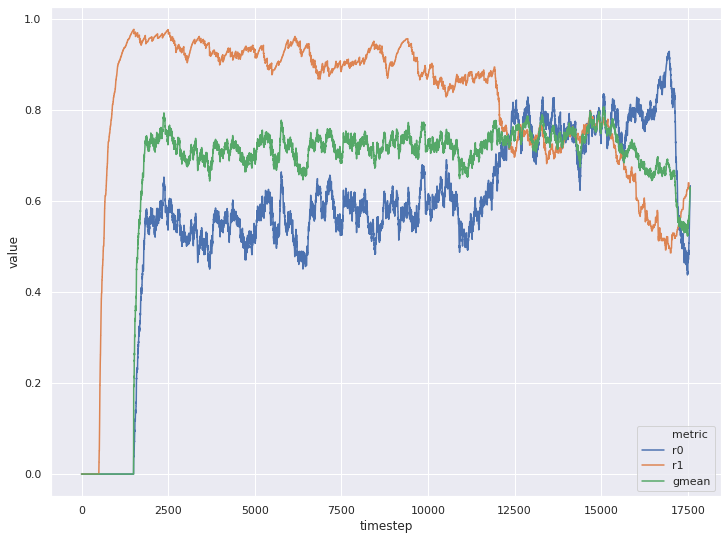

In [66]:
prequential_recalls = metrics.prequential_recalls_gmean(results, .99)
plot_recalls_gmean(prequential_recalls)